In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Prova


In [ ]:
import os
from shutil import move
from sklearn.model_selection import train_test_split

# Percorso alla cartella di addestramento
train_dir = '/content/drive/My Drive/Front_dataset/Train'

# Percorso alla cartella di validazione (all'interno di Front_dataset)
validation_dir = '/content/drive/My Drive/Front_dataset/Validation'

# Crea la cartella di validazione
os.mkdir(validation_dir)

# Ottieni la lista delle sottocartelle nella cartella di addestramento
subfolders = [f.name for f in os.scandir(train_dir) if f.is_dir()]

# Per ogni sottocartella, crea la corrispondente sottocartella nella cartella di validazione
for subfolder in subfolders:
    os.mkdir(os.path.join(validation_dir, subfolder))

    # Ottieni la lista dei nomi dei file nella sottocartella di addestramento
    subfolder_path = os.path.join(train_dir, subfolder)
    file_names = os.listdir(subfolder_path)

    # Dividi i dati in addestramento e validazione per questa sottocartella
    train_files, validation_files = train_test_split(file_names, test_size=0.2, random_state=42)

    # Sposta i file di validazione nella sottocartella corrispondente nella cartella di validazione
    for file_name in validation_files:
        src_path = os.path.join(subfolder_path, file_name)
        dst_path = os.path.join(validation_dir, subfolder, file_name)
        move(src_path, dst_path)

print("Cartella di validazione creata e dati spostati.")


Cartella di validazione creata e dati spostati.


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1360 files belonging to 5 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 343 files belonging to 5 classes.


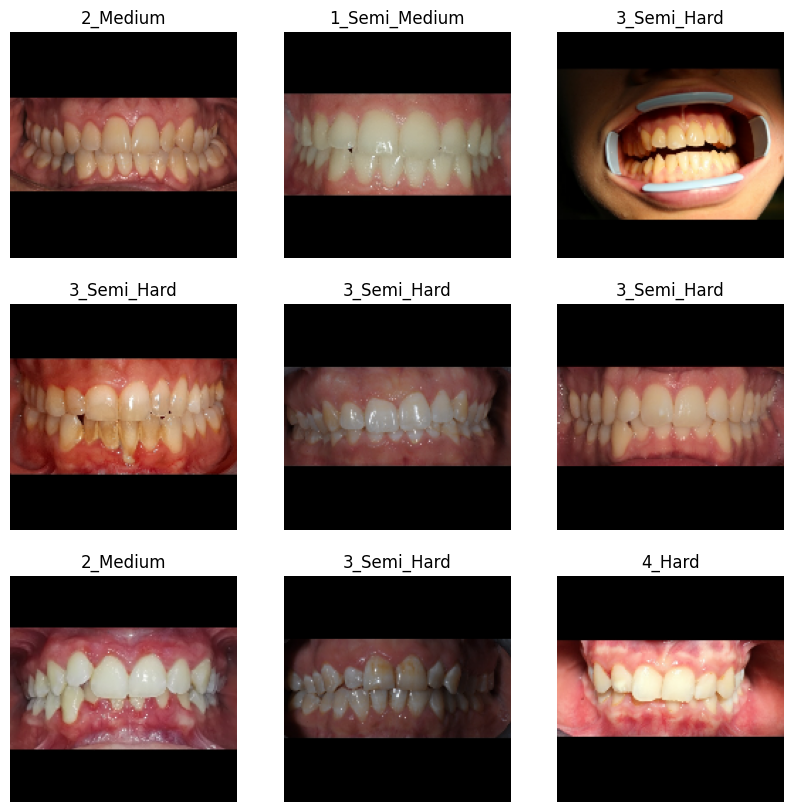

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 429 files belonging to 5 classes.


In [ ]:
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of test batches: 14


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

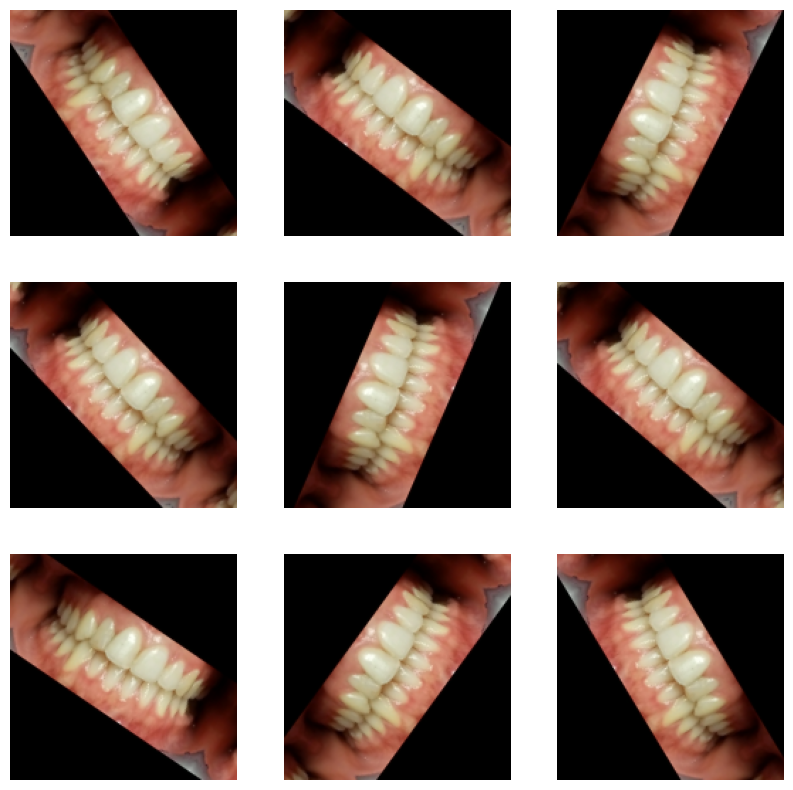

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Crea il modello base dalle convnet pre-addestrate

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


Estrazione delle caratteristiche

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Aggiungi una testata di classificazione

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Compila il modello

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

11/11 [==============================] - 56s 827ms/step - loss: 3.2768 - accuracy: 0.0612


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.28
initial accuracy: 0.06


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
43/43 [==============================] - 151s 3s/step - loss: 0.6174 - accuracy: 0.1037 - val_loss: -1.0856 - val_accuracy: 0.1808
Epoch 2/10
43/43 [==============================] - 5s 97ms/step - loss: -2.7427 - accuracy: 0.1772 - val_loss: -4.2093 - val_accuracy: 0.1983
Epoch 3/10
43/43 [==============================] - 6s 128ms/step - loss: -5.3690 - accuracy: 0.1963 - val_loss: -6.9503 - val_accuracy: 0.1983
Epoch 4/10
43/43 [==============================] - 5s 96ms/step - loss: -7.9597 - accuracy: 0.1971 - val_loss: -9.7169 - val_accuracy: 0.1983
Epoch 5/10
43/43 [==============================] - 5s 95ms/step - loss: -10.3883 - accuracy: 0.1971 - val_loss: -12.5463 - val_accuracy: 0.1983
Epoch 6/10
43/43 [==============================] - 6s 128ms/step - loss: -13.3531 - accuracy: 0.1971 - val_loss: -15.4627 - val_accuracy: 0.1983
Epoch 7/10
43/43 [==============================] - 5s 96ms/step - loss: -15.9953 - accuracy: 0.1971 - val_loss: -18.4464 - val_accuracy:

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
43/43 [==============================] - 22s 125ms/step - loss: -212.4427 - accuracy: 0.1971 - val_loss: -317.5150 - val_accuracy: 0.1983
Epoch 11/20
43/43 [==============================] - 7s 150ms/step - loss: -350.5130 - accuracy: 0.1971 - val_loss: -364.2744 - val_accuracy: 0.1983
Epoch 12/20
43/43 [==============================] - 5s 100ms/step - loss: -375.4649 - accuracy: 0.1971 - val_loss: -382.9865 - val_accuracy: 0.1983
Epoch 13/20
43/43 [==============================] - 6s 135ms/step - loss: -389.4263 - accuracy: 0.1971 - val_loss: -393.4042 - val_accuracy: 0.1983
Epoch 14/20
43/43 [==============================] - 5s 103ms/step - loss: -396.9130 - accuracy: 0.1971 - val_loss: -398.9416 - val_accuracy: 0.1983
Epoch 15/20
43/43 [==============================] - 6s 138ms/step - loss: -402.1949 - accuracy: 0.1971 - val_loss: -402.9503 - val_accuracy: 0.1983
Epoch 16/20
43/43 [==============================] - 5s 103ms/step - loss: -405.3440 - accuracy: 0.1971 -

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

14/14 [==============================] - 68s 2s/step - loss: -417.8143 - accuracy: 0.1981
Test accuracy : 0.19813519716262817


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [4 2 0 3 4 3 1 4 3 3 2 0 2 4 4 3 3 2 2 4 1 4 3 1 3 1 3 1 4 2 4 2]


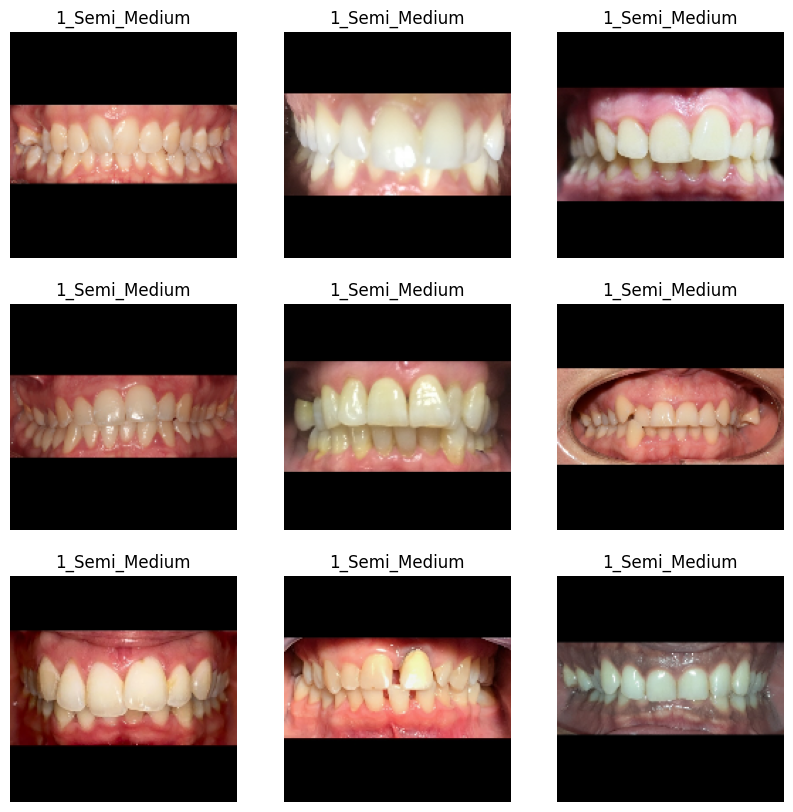

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
# fa schifo

### VGG16 solo con front


In [ ]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam

# Carica il modello VGG16 pre-addestrato (senza il top completamente connesso)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Aggiungi uno strato di Global Average Pooling e uno strato completamente connesso
num_classes = 5
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Cambia 'num_classes' con il numero delle tue classi

# Crea il modello finale
model = Model(inputs=base_model.input, outputs=predictions)

# Blocca i pesi del modello base per l'addestramento
for layer in base_model.layers:
    layer.trainable = False


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
train_dir = '/content/drive/My Drive/Front_dataset_v2/Train'

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 32
num_epochs = 30
# Definisci le trasformazioni di data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Carica i dati con le trasformazioni di data augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')



Found 2037 images belonging to 5 classes.


In [ ]:
test_dir = '/content/drive/My Drive/Front_dataset_v2/Test'

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 32
num_epochs = 30
# Definisci le trasformazioni di data augmentation
test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Carica i dati con le trasformazioni di data augmentation
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

Found 358 images belonging to 5 classes.


In [ ]:
model.fit(train_generator,
          epochs=30,
          validation_data=test_generator)


Epoch 1/30
64/64 [==============================] - 568s 9s/step - loss: 1.4756 - accuracy: 0.3171 - val_loss: 1.4972 - val_accuracy: 0.3128
Epoch 2/30
64/64 [==============================] - 42s 649ms/step - loss: 1.4756 - accuracy: 0.3373 - val_loss: 1.4899 - val_accuracy: 0.3156
Epoch 3/30
64/64 [==============================] - 41s 649ms/step - loss: 1.4715 - accuracy: 0.3206 - val_loss: 1.4674 - val_accuracy: 0.3492
Epoch 4/30
64/64 [==============================] - 41s 647ms/step - loss: 1.4721 - accuracy: 0.3220 - val_loss: 1.4832 - val_accuracy: 0.3296
Epoch 5/30
64/64 [==============================] - 45s 700ms/step - loss: 1.4551 - accuracy: 0.3368 - val_loss: 1.4933 - val_accuracy: 0.3212
Epoch 6/30
64/64 [==============================] - 42s 659ms/step - loss: 1.4522 - accuracy: 0.3535 - val_loss: 1.4762 - val_accuracy: 0.3352
Epoch 7/30
64/64 [==============================] - 42s 652ms/step - loss: 1.4511 - accuracy: 0.3441 - val_loss: 1.5348 - val_accuracy: 0.2709
E

In [ ]:
predictions = model.predict(test_generator)



12/12 [==============================] - 132s 12s/step


In [ ]:
model.evaluate(test_generator)

12/12 [==============================] - 6s 525ms/step - loss: 1.4947 - accuracy: 0.3603


[1.4947224855422974, 0.36033520102500916]

In [ ]:
from keras.callbacks import ModelCheckpoint

# Definisci una callback per il salvataggio dei pesi migliori
checkpoint = ModelCheckpoint('best_model_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max', verbose=1)

# Addestra il modello utilizzando la callback di salvataggio
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=test_generator,
                    callbacks=[checkpoint])

# Carica i pesi migliori ottenuti durante l'addestramento
model.load_weights('best_model_weights.h5')


Epoch 1/30
43/43 [==============================] - ETA: 0s - loss: 1.3827 - accuracy: 0.3904
Epoch 1: val_accuracy improved from -inf to 0.33566, saving model to best_model_weights.h5
43/43 [==============================] - 31s 733ms/step - loss: 1.3827 - accuracy: 0.3904 - val_loss: 1.4880 - val_accuracy: 0.3357
Epoch 2/30
43/43 [==============================] - ETA: 0s - loss: 1.3768 - accuracy: 0.3846
Epoch 2: val_accuracy improved from 0.33566 to 0.34033, saving model to best_model_weights.h5
43/43 [==============================] - 35s 811ms/step - loss: 1.3768 - accuracy: 0.3846 - val_loss: 1.4561 - val_accuracy: 0.3403
Epoch 3/30
43/43 [==============================] - ETA: 0s - loss: 1.3755 - accuracy: 0.4059
Epoch 3: val_accuracy did not improve from 0.34033
43/43 [==============================] - 32s 740ms/step - loss: 1.3755 - accuracy: 0.4059 - val_loss: 1.4936 - val_accuracy: 0.3310
Epoch 4/30
43/43 [==============================] - ETA: 0s - loss: 1.3774 - accuracy:

In [ ]:
### double prediction
# Esegui le previsioni sul batch di immagini di test
predictions = model.predict(test_generator)

# Soglia di confidenza
confidence_threshold = 0.7  # Puoi regolare questo valore in base alle tue esigenze

# Lista per immagazzinare le previsioni modificate
modified_predictions = []

# Loop attraverso le previsioni
for pred in predictions:
    max_class_prob = np.max(pred)  # Massima probabilità predetta
    if max_class_prob >= confidence_threshold:
        # Se la classe principale ha una probabilità sufficientemente alta, aggiungi solo quella
        modified_predictions.append(pred.argmax())
    else:
        # Se la probabilità non è sufficientemente alta, aggiungi le due classi più probabili
        top_classes = pred.argsort()[-2:][::-1]
        modified_predictions.append(top_classes)

# Converti in formato array numpy
modified_predictions = np.array(modified_predictions)

12/12 [==============================] - 6s 466ms/step


In [ ]:
true_labels = test_generator.classes

# Assicurati che le true_labels siano un array NumPy
true_labels = np.array(true_labels)


In [ ]:
# Calculate accuracy
accuracy = np.mean([np.any(true_label == modified_predictions) for true_label, modified_predictions in zip(true_labels, modified_predictions)])

print("Accuracy:", accuracy)

Accuracy: 0.49441340782122906


In [ ]:
class_indices = np.argsort(predictions, axis=1)

# Seleziona le due classi con le probabilità più alte
top2_class_indices = class_indices[:, -2:]


In [ ]:
import numpy as np
correct_predictions = [true_label in top2_indices for true_label, top2_indices in zip(true_labels, top2_class_indices)]

# Calcola l'accuracy
accuracy = np.mean(correct_predictions)

print("Accuracy:", accuracy)


Accuracy: 0.4972067039106145


In [ ]:
### double adj
import numpy as np

# Supponiamo che "predictions" sia un array di probabilità previste per le tue immagini
# Ad esempio, se hai 2 classi, "predictions" sarà un array di dimensioni (numero_di_immagini, 2)

# Trova gli indici delle classi in base alle probabilità previste
class_indices = np.argsort(predictions, axis=1)

# Seleziona le due classi con le probabilità più alte
top2_class_indices = class_indices[:, -2:]  # Prendi gli ultimi due indici (quelli con le probabilità più alte)

# Supponiamo che "true_labels" sia una lista o un array di NumPy con le etichette vere delle immagini
# E supponiamo che le etichette siano ordinate in modo che la classe 0 sia adiacente alla classe 1

# Inizializza una lista per salvare la classe con la probabilità più alta e quella adiacente con probabilità più alta
best_class_pairs = []

for i, true_label in enumerate(true_labels):
    top2_indices = top2_class_indices[i]
    top2_probs = predictions[i, top2_indices]

    # Ordina top2_indices in modo crescente in base alle probabilità corrispondenti
    sorted_indices = top2_indices[np.argsort(top2_probs)]

    # La classe adiacente è quella con indice minore tra le due
    adjacent_class = min(sorted_indices)
    highest_prob_class = max(sorted_indices)

    best_class_pairs.append((highest_prob_class, adjacent_class))

# Ora "best_class_pairs" contiene le coppie di classi con la probabilità più alta e quella adiacente con probabilità più alta per ciascuna immagine


In [ ]:
correct_predictions = [true_label in best_class_pairs for true_label, best_class_pairs in zip(true_labels, best_class_pairs)]

# Calcola l'accuracy
accuracy = np.mean(correct_predictions)

print("Accuracy:", accuracy)

Accuracy: 0.4972067039106145


### VGG16 front con fine-tuning

In [ ]:
# Sblocca alcuni strati superiori del modello base per il fine-tuning
for layer in base_model.layers[:100]:
    layer.trainable = True

# Ricompila il modello con un tasso di apprendimento più piccolo per il fine-tuning
model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continua l'addestramento con il fine-tuning
model.fit(train_generator,
          epochs=30,
          validation_data=test_generator)


Epoch 1/30
43/43 [==============================] - 518s 11s/step - loss: 1.9575 - accuracy: 0.2515 - val_loss: 1.5281 - val_accuracy: 0.2797
Epoch 2/30
43/43 [==============================] - 32s 744ms/step - loss: 1.5310 - accuracy: 0.2765 - val_loss: 1.5675 - val_accuracy: 0.2657
Epoch 3/30
43/43 [==============================] - 33s 775ms/step - loss: 1.5363 - accuracy: 0.2426 - val_loss: 1.5243 - val_accuracy: 0.2797
Epoch 4/30
43/43 [==============================] - 36s 827ms/step - loss: 1.5398 - accuracy: 0.2801 - val_loss: 1.5253 - val_accuracy: 0.2797
Epoch 5/30
43/43 [==============================] - 34s 793ms/step - loss: 1.5285 - accuracy: 0.2794 - val_loss: 1.5245 - val_accuracy: 0.2797
Epoch 6/30
43/43 [==============================] - 35s 820ms/step - loss: 1.5257 - accuracy: 0.2647 - val_loss: 1.5279 - val_accuracy: 0.2797
Epoch 7/30
43/43 [==============================] - 33s 767ms/step - loss: 1.5273 - accuracy: 0.2676 - val_loss: 1.5240 - val_accuracy: 0.2797


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test accuracy:", test_accuracy)

14/14 [==============================] - 7s 510ms/step - loss: 1.5212 - accuracy: 0.2797
Test accuracy: 0.279720276594162


In [ ]:
true_labels = test_generator.classes

# Assicurati che le true_labels siano un array NumPy
true_labels = np.array(true_labels)

In [ ]:
predictions = model.predict(test_generator)

# Soglia di confidenza
confidence_threshold = 0.7  # Puoi regolare questo valore in base alle tue esigenze

# Lista per immagazzinare le previsioni modificate
modified_predictions = []

# Loop attraverso le previsioni
for pred in predictions:
    max_class_prob = np.max(pred)  # Massima probabilità predetta
    if max_class_prob >= confidence_threshold:
        # Se la classe principale ha una probabilità sufficientemente alta, aggiungi solo quella
        modified_predictions.append(pred.argmax())
    else:
        # Se la probabilità non è sufficientemente alta, aggiungi le due classi più probabili
        top_classes = pred.argsort()[-2:][::-1]
        modified_predictions.append(top_classes)

# Converti in formato array numpy
modified_predictions = np.array(modified_predictions)

14/14 [==============================] - 9s 568ms/step


In [ ]:
correct_predictions = [true_label in modified_predictions for true_label, modified_predictions in zip(true_labels, modified_predictions)]

# Calcola l'accuracy
accuracy = np.mean(correct_predictions)

print("Accuracy:", accuracy)

Accuracy: 0.5454545454545454


In [ ]:
import numpy as np

# Supponiamo che "predictions" sia un array di probabilità previste per le tue immagini
# Ad esempio, se hai 2 classi, "predictions" sarà un array di dimensioni (numero_di_immagini, 2)

# Trova gli indici delle classi in base alle probabilità previste
class_indices = np.argsort(predictions, axis=1)

# Seleziona le due classi con le probabilità più alte
top2_class_indices = class_indices[:, -2:]  # Prendi gli ultimi due indici (quelli con le probabilità più alte)

# Supponiamo che "true_labels" sia una lista o un array di NumPy con le etichette vere delle immagini
# E supponiamo che le etichette siano ordinate in modo che la classe 0 sia adiacente alla classe 1

# Inizializza una lista per salvare la classe con la probabilità più alta e quella adiacente con probabilità più alta
best_class_pairs = []

for i, true_label in enumerate(true_labels):
    top2_indices = top2_class_indices[i]
    top2_probs = predictions[i, top2_indices]

    # Ordina top2_indices in modo crescente in base alle probabilità corrispondenti
    sorted_indices = top2_indices[np.argsort(top2_probs)]

    # La classe adiacente è quella con indice minore tra le due
    adjacent_class = min(sorted_indices)
    highest_prob_class = max(sorted_indices)

    best_class_pairs.append((highest_prob_class, adjacent_class))


In [ ]:
correct_predictions = [true_label in best_class_pairs for true_label, best_class_pairs in zip(true_labels, best_class_pairs)]

# Calcola l'accuracy
accuracy = np.mean(correct_predictions)

print("Accuracy:", accuracy)

Accuracy: 0.5454545454545454


### VGG19

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Specifica la dimensione delle immagini in input (adatta al tuo caso)
input_shape = (224, 224, 3)

# Carica il modello VGG19 pre-addestrato senza i top fully connected layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Aggiungi uno strato di Global Average Pooling e uno strato completamente connesso personalizzato
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Puoi regolare il numero di unità a seconda delle tue esigenze
predictions = Dense(5, activation='softmax')(x)  # "num_classes" è il numero di classi nel tuo problema

# Crea il modello finale
model = Model(inputs=base_model.input, outputs=predictions)

# Blocca i pesi del modello base per l'addestramento
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Ora il modello VGG19 è pronto per il fine-tuning con i tuoi dati di immagini dentali


80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
model.fit(train_generator,
          epochs=30,
          validation_data=test_generator)

Epoch 1/30
64/64 [==============================] - 46s 688ms/step - loss: 1.5484 - accuracy: 0.2936 - val_loss: 1.5642 - val_accuracy: 0.2039
Epoch 2/30
64/64 [==============================] - 43s 667ms/step - loss: 1.5112 - accuracy: 0.3009 - val_loss: 1.5242 - val_accuracy: 0.3268
Epoch 3/30
64/64 [==============================] - 42s 661ms/step - loss: 1.5172 - accuracy: 0.3039 - val_loss: 1.5391 - val_accuracy: 0.2933
Epoch 4/30
64/64 [==============================] - 42s 656ms/step - loss: 1.4914 - accuracy: 0.3142 - val_loss: 1.5328 - val_accuracy: 0.2598
Epoch 5/30
64/64 [==============================] - 42s 656ms/step - loss: 1.4910 - accuracy: 0.3063 - val_loss: 1.5308 - val_accuracy: 0.2793
Epoch 6/30
64/64 [==============================] - 43s 665ms/step - loss: 1.4969 - accuracy: 0.3068 - val_loss: 1.5093 - val_accuracy: 0.3156
Epoch 7/30
64/64 [==============================] - 43s 667ms/step - loss: 1.4872 - accuracy: 0.3289 - val_loss: 1.5161 - val_accuracy: 0.2933

In [ ]:
model.evaluate(test_generator)

12/12 [==============================] - 7s 552ms/step - loss: 1.4918 - accuracy: 0.3408


[1.4918453693389893, 0.34078213572502136]

In [ ]:
# Esegui le previsioni sul batch di immagini di test
predictions = model.predict(test_generator)

# Soglia di confidenza
confidence_threshold = 0.7  # Puoi regolare questo valore in base alle tue esigenze

# Lista per immagazzinare le previsioni modificate
modified_predictions = []

# Loop attraverso le previsioni
for pred in predictions:
    max_class_prob = np.max(pred)  # Massima probabilità predetta
    if max_class_prob >= confidence_threshold:
        # Se la classe principale ha una probabilità sufficientemente alta, aggiungi solo quella
        modified_predictions.append(pred.argmax())
    else:
        # Se la probabilità non è sufficientemente alta, aggiungi le due classi più probabili
        top_classes = pred.argsort()[-2:][::-1]
        modified_predictions.append(top_classes)

# Converti in formato array numpy
modified_predictions = np.array(modified_predictions)

12/12 [==============================] - 6s 516ms/step


In [ ]:
accuracy = np.mean([np.any(true_label == modified_predictions) for true_label, modified_predictions in zip(true_labels, modified_predictions)])

print("Accuracy:", accuracy)

Accuracy: 0.5167597765363129


In [ ]:
import numpy as np

# Supponiamo che "predictions" sia un array di probabilità previste per le tue immagini
# Ad esempio, se hai 2 classi, "predictions" sarà un array di dimensioni (numero_di_immagini, 2)

# Trova gli indici delle classi in base alle probabilità previste
class_indices = np.argsort(predictions, axis=1)

# Seleziona le due classi con le probabilità più alte
top2_class_indices = class_indices[:, -2:]  # Prendi gli ultimi due indici (quelli con le probabilità più alte)

# Supponiamo che "true_labels" sia una lista o un array di NumPy con le etichette vere delle immagini
# E supponiamo che le etichette siano ordinate in modo che la classe 0 sia adiacente alla classe 1

# Inizializza una lista per salvare la classe con la probabilità più alta e quella adiacente con probabilità più alta
best_class_pairs = []

for i, true_label in enumerate(true_labels):
    top2_indices = top2_class_indices[i]
    top2_probs = predictions[i, top2_indices]

    # Ordina top2_indices in modo crescente in base alle probabilità corrispondenti
    sorted_indices = top2_indices[np.argsort(top2_probs)]

    # La classe adiacente è quella con indice minore tra le due
    adjacent_class = min(sorted_indices)
    highest_prob_class = max(sorted_indices)

    best_class_pairs.append((highest_prob_class, adjacent_class))

In [ ]:
import numpy as np

# Esempio di previsioni dal tuo modello
predictions = model.predict(test_generator)

# True labels
true_labels = test_generator.classes
true_labels = np.array(true_labels)

class_indices = np.argsort(predictions, axis=1)

# Seleziona le due classi con le probabilità più alte
top2_class_indices = class_indices[:, -2:]  # Prendi gli ultimi due indici (quelli con le probabilità più alte)

# Supponiamo che "true_labels" sia una lista o un array di NumPy con le etichette vere delle immagini
# E supponiamo che le etichette siano ordinate in modo che la classe 0 sia adiacente alla classe 1

# Inizializza una lista per salvare la classe con la probabilità più alta e quella adiacente con probabilità più alta
best_class_pairs = []

for i, true_label in enumerate(true_labels):
    top2_indices = top2_class_indices[i]
    top2_probs = predictions[i, top2_indices]

    # Ordina top2_indices in modo crescente in base alle probabilità corrispondenti
    sorted_indices = top2_indices[np.argsort(top2_probs)]

    # La classe adiacente è quella con indice minore tra le due
    adjacent_class = min(sorted_indices)
    highest_prob_class = max(sorted_indices)

    best_class_pairs.append((highest_prob_class, adjacent_class))


12/12 [==============================] - 7s 594ms/step


In [ ]:
correct_predictions = [true_label in best_class_pairs for true_label, best_class_pairs in zip(true_labels, best_class_pairs)]

# Calcola l'accuracy
accuracy = np.mean(correct_predictions)

print("Accuracy:", accuracy)

Accuracy: 0.5027932960893855


### VGG16 CON 5 angolazioni


In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import zipfile
from pathlib import Path
import requests
from typing import List, Tuple
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns
import sys

In [ ]:
# non runnare
# Percorso alla cartella di validazione (all'interno di Front_dataset)
validation_dir = '/content/drive/My Drive/Stat_Learn_Final_Proj_ramona/All_views_v2/Test'

# Crea la cartella di validazione
os.mkdir(validation_dir)

# Ottieni la lista delle sottocartelle nella cartella di addestramento
subfolders = [f.name for f in os.scandir(train_dir) if f.is_dir()]

# Per ogni sottocartella, crea la corrispondente sottocartella nella cartella di validazione
for subfolder in subfolders:
    os.mkdir(os.path.join(validation_dir, subfolder))

    # Ottieni la lista dei nomi dei file nella sottocartella di addestramento
    subfolder_path = os.path.join(train_dir, subfolder)
    file_names = os.listdir(subfolder_path)

    # Dividi i dati in addestramento e validazione per questa sottocartella
    train_files, validation_files = train_test_split(file_names, test_size=0.2, random_state=42)

    # Sposta i file di validazione nella sottocartella corrispondente nella cartella di validazione
    for file_name in validation_files:
        src_path = os.path.join(subfolder_path, file_name)
        dst_path = os.path.join(validation_dir, subfolder, file_name)
        move(src_path, dst_path)

print("Cartella di validazione creata e dati spostati.")

In [ ]:
train_dir = '/content/drive/My Drive/Stat_Learn_Final_Proj_ramona/All_views_v2/Train'
test_dir = '/content/drive/My Drive/Stat_Learn_Final_Proj_ramona/All_views_v2/Test'


In [ ]:
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Carica i dati con le trasformazioni di data augmentation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

Found 1229 images belonging to 5 classes.


In [ ]:
batch_size = 32
test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Carica i dati con le trasformazioni di data augmentation
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

Found 218 images belonging to 5 classes.


In [ ]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam

# Carica il modello VGG16 pre-addestrato (senza il top completamente connesso)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Aggiungi uno strato di Global Average Pooling e uno strato completamente connesso
num_classes = 5
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Cambia 'num_classes' con il numero delle tue classi

# Crea il modello finale
model = Model(inputs=base_model.input, outputs=predictions)

# Blocca i pesi del modello base per l'addestramento
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Addestra il modello
model.fit(train_generator,
          epochs=30,
          validation_data=test_generator)

In [ ]:
# Esegui le previsioni sul batch di immagini di test
predictions = model.predict(test_generator)

# Soglia di confidenza
confidence_threshold = 0.7  # Puoi regolare questo valore in base alle tue esigenze

# Lista per immagazzinare le previsioni modificate
modified_predictions = []

# Loop attraverso le previsioni
for pred in predictions:
    max_class_prob = np.max(pred)  # Massima probabilità predetta
    if max_class_prob >= confidence_threshold:
        # Se la classe principale ha una probabilità sufficientemente alta, aggiungi solo quella
        modified_predictions.append(pred.argmax())
    else:
        # Se la probabilità non è sufficientemente alta, aggiungi le due classi più probabili
        top_classes = pred.argsort()[-2:][::-1]
        modified_predictions.append(top_classes)

# Converti in formato array numpy
modified_predictions = np.array(modified_predictions)


16/16 [==============================] - 9s 550ms/step


In [ ]:
model.evaluate(test_generator)


16/16 [==============================] - 8s 473ms/step - loss: 1.4350 - accuracy: 0.3808


[1.4349892139434814, 0.3807615339756012]

In [ ]:
# Calculate accuracy
accuracy = np.mean([np.any(true_label == modified_predictions) for true_label, modified_predictions in zip(true_labels, modified_predictions)])

print("Accuracy:", accuracy)

Accuracy: 0.43286573146292584


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test accuracy:", test_accuracy)

16/16 [==============================] - 11s 662ms/step - loss: 1.4012 - accuracy: 0.4108
Test accuracy: 0.4108216464519501


### Prova dando maggior peso alla classe 0

In [ ]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
import numpy as np

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Aggiungi uno strato di Global Average Pooling e uno strato completamente connesso
num_classes = 5
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Cambia 'num_classes' con il numero delle tue classi

# Crea il modello finale
model = Model(inputs=base_model.input, outputs=predictions)

# Blocca i pesi del modello base per l'addestramento
for layer in base_model.layers:
    layer.trainable = False
# Definisci i pesi delle classi per dare maggior importanza alla classe '0_Soft'
class_weights = {0: 10.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 10.0}  # Esempio: attribuisce maggior peso alla classe 4




In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:

model.fit(train_generator,
          epochs=30,
          validation_data=validation_generator, class_weight=class_weights)


Epoch 1/30
98/98 [==============================] - 67s 677ms/step - loss: 3.8529 - accuracy: 0.2035 - val_loss: 2.7562 - val_accuracy: 0.2058
Epoch 2/30
98/98 [==============================] - 69s 700ms/step - loss: 3.7093 - accuracy: 0.2080 - val_loss: 2.2853 - val_accuracy: 0.2058
Epoch 3/30
98/98 [==============================] - 68s 690ms/step - loss: 3.5313 - accuracy: 0.2140 - val_loss: 2.0381 - val_accuracy: 0.1995
Epoch 4/30
98/98 [==============================] - 75s 767ms/step - loss: 3.4831 - accuracy: 0.2207 - val_loss: 1.8078 - val_accuracy: 0.2300
Epoch 5/30
98/98 [==============================] - 66s 669ms/step - loss: 3.4005 - accuracy: 0.2418 - val_loss: 1.9028 - val_accuracy: 0.2452
Epoch 6/30
98/98 [==============================] - 67s 685ms/step - loss: 3.3353 - accuracy: 0.2507 - val_loss: 2.1766 - val_accuracy: 0.2122
Epoch 7/30
98/98 [==============================] - 66s 674ms/step - loss: 3.3469 - accuracy: 0.2581 - val_loss: 1.9236 - val_accuracy: 0.2516

In [ ]:
predictions = model.predict(test_generator)

# Soglia di confidenza
confidence_threshold = 0.7  # Puoi regolare questo valore in base alle tue esigenze

# Lista per immagazzinare le previsioni modificate
modified_predictions = []

# Loop attraverso le previsioni
for pred in predictions:
    max_class_prob = np.max(pred)  # Massima probabilità predetta
    if max_class_prob >= confidence_threshold:
        # Se la classe principale ha una probabilità sufficientemente alta, aggiungi solo quella
        modified_predictions.append(pred.argmax())
    else:
        # Se la probabilità non è sufficientemente alta, aggiungi le due classi più probabili
        top_classes = pred.argsort()[-2:][::-1]
        modified_predictions.append(top_classes)

# Converti in formato array numpy
modified_predictions = np.array(modified_predictions)

16/16 [==============================] - 8s 515ms/step


In [ ]:
modified_predictions

array([array([4, 2]), 4, 4, array([4, 2]), array([3, 4]), array([4, 3]),
       array([4, 2]), array([4, 3]), 4, array([4, 2]), array([4, 3]),
       array([4, 2]), array([4, 2]), array([4, 2]), array([3, 0]),
       array([4, 3]), array([3, 1]), array([4, 2]), array([3, 4]),
       array([4, 2]), 4, array([4, 3]), 3, array([4, 2]), array([4, 3]),
       array([3, 4]), array([3, 4]), array([4, 3]), array([3, 0]),
       array([4, 2]), 3, array([4, 2]), array([4, 0]), 3, array([4, 2]),
       array([4, 2]), array([4, 2]), array([4, 2]), array([3, 1]),
       array([4, 2]), array([4, 2]), 4, array([3, 4]), array([4, 2]),
       array([0, 4]), array([4, 2]), 4, array([4, 0]), 3, array([4, 3]),
       array([3, 4]), array([4, 2]), 4, array([0, 4]), array([3, 4]),
       array([4, 3]), array([4, 0]), array([4, 3]), array([4, 2]),
       array([4, 2]), array([3, 1]), array([4, 2]), array([4, 3]),
       array([4, 0]), array([0, 3]), array([4, 2]), array([4, 2]),
       array([4, 2]), array([

In [ ]:
accuracy = np.mean([np.any(true_label == modified_predictions) for true_label, modified_predictions in zip(true_labels, modified_predictions)])

print("Accuracy:", accuracy)

Accuracy: 0.33867735470941884


### efficientnet

In [ ]:
pip install efficientnet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.9 MB/s eta 0:00:00


In [ ]:
import efficientnet.keras as efn

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

validation_generator = test_datagen.flow_from_directory( validation_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 3135 images belonging to 5 classes.
Found 787 images belonging to 5 classes.


In [ ]:
base_model = efn.EfficientNetB0(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

16804768/16804768 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
predictions = Dense(1, activation="sigmoid")(x)
model_final = Model(base_model.input,predictions)

In [ ]:
# Compila il modello utilizzando l'ottimizzatore RMSprop legacy
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])


In [ ]:
eff_history = model_final.fit_generator(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)


Epoch 1/10
100/100 [==============================] - 48s 386ms/step - loss: -46243.1602 - accuracy: 0.2080 - val_loss: -133552.1562 - val_accuracy: 0.2008
Epoch 2/10
100/100 [==============================] - 39s 390ms/step - loss: -218581.7188 - accuracy: 0.1995 - val_loss: -406400.6875 - val_accuracy: 0.2008
Epoch 3/10
100/100 [==============================] - 39s 386ms/step - loss: -493453.6875 - accuracy: 0.2045 - val_loss: -812086.1875 - val_accuracy: 0.2008
Epoch 4/10
100/100 [==============================] - 37s 371ms/step - loss: -891446.8125 - accuracy: 0.2010 - val_loss: -1349499.8750 - val_accuracy: 0.2008
Epoch 5/10
100/100 [==============================] - 37s 362ms/step - loss: -1395218.7500 - accuracy: 0.2030 - val_loss: -2023529.3750 - val_accuracy: 0.2008
Epoch 6/10
100/100 [==============================] - 36s 363ms/step - loss: -1994775.0000 - accuracy: 0.2105 - val_loss: -2828766.5000 - val_accuracy: 0.2008
Epoch 7/10
100/100 [==============================] - 

### DenseNet121 - front


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Specifica la dimensione delle immagini in input (adatta al tuo caso)
input_shape = (224, 224, 3)

# Carica il modello DenseNet121 pre-addestrato senza i top fully connected layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Aggiungi uno strato di Global Average Pooling e uno strato completamente connesso personalizzato
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Puoi regolare il numero di unità a seconda delle tue esigenze
predictions = Dense(5, activation='softmax')(x)  # "num_classes" è il numero di classi nel tuo problema

# Crea il modello finale
model = Model(inputs=base_model.input, outputs=predictions)

# Blocca i pesi del modello base per l'addestramento
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Ora il modello è pronto per il fine-tuning con i tuoi dati di immagini dentali


29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
model.fit(train_generator,
          epochs=30,
          validation_data=test_generator)


Epoch 1/30
64/64 [==============================] - 55s 724ms/step - loss: 1.7161 - accuracy: 0.3019 - val_loss: 1.5597 - val_accuracy: 0.3156
Epoch 2/30
64/64 [==============================] - 41s 635ms/step - loss: 1.4739 - accuracy: 0.3476 - val_loss: 1.5063 - val_accuracy: 0.2877
Epoch 3/30
64/64 [==============================] - 45s 697ms/step - loss: 1.4601 - accuracy: 0.3392 - val_loss: 1.4739 - val_accuracy: 0.3017
Epoch 4/30
64/64 [==============================] - 42s 655ms/step - loss: 1.4277 - accuracy: 0.3446 - val_loss: 1.5440 - val_accuracy: 0.3156
Epoch 5/30
64/64 [==============================] - 41s 639ms/step - loss: 1.4076 - accuracy: 0.3721 - val_loss: 1.5303 - val_accuracy: 0.3324
Epoch 6/30
64/64 [==============================] - 39s 611ms/step - loss: 1.4090 - accuracy: 0.3623 - val_loss: 1.4792 - val_accuracy: 0.3408
Epoch 7/30
64/64 [==============================] - 41s 639ms/step - loss: 1.4175 - accuracy: 0.3706 - val_loss: 1.5053 - val_accuracy: 0.3045

In [ ]:
model.evaluate(test_generator)

12/12 [==============================] - 9s 696ms/step - loss: 1.4850 - accuracy: 0.3352


[1.4849690198898315, 0.33519554138183594]

In [ ]:
true_labels = test_generator.classes

# Assicurati che le true_labels siano un array NumPy
true_labels = np.array(true_labels)


In [ ]:

# Esegui le previsioni sul batch di immagini di test
predictions = model.predict(test_generator)

# Soglia di confidenza
confidence_threshold = 0.7 # Puoi regolare questo valore in base alle tue esigenze

# Lista per immagazzinare le previsioni modificate
modified_predictions = []

# Loop attraverso le previsioni
for pred in predictions:
    max_class_prob = np.max(pred)  # Massima probabilità predetta
    if max_class_prob >= confidence_threshold:
        # Se la classe principale ha una probabilità sufficientemente alta, aggiungi solo quella
        modified_predictions.append(pred.argmax())
    else:
        # Se la probabilità non è sufficientemente alta, aggiungi le due classi più probabili
        top_classes = pred.argsort()[-2:][::-1]
        modified_predictions.append(top_classes)

# Converti in formato array numpy
modified_predictions = np.array(modified_predictions)

12/12 [==============================] - 9s 592ms/step


In [ ]:
# Calculate accuracy
accuracy = np.mean([np.any(true_label == modified_predictions) for true_label, modified_predictions in zip(true_labels, modified_predictions)])

print("Accuracy:", accuracy)

Accuracy: 0.5027932960893855


In [ ]:
import numpy as np

# Supponiamo che "predictions" sia un array di probabilità previste per le tue immagini
# Ad esempio, se hai 2 classi, "predictions" sarà un array di dimensioni (numero_di_immagini, 2)

# Trova gli indici delle classi in base alle probabilità previste
class_indices = np.argsort(predictions, axis=1)

# Seleziona le due classi con le probabilità più alte
top2_class_indices = class_indices[:, -2:]  # Prendi gli ultimi due indici (quelli con le probabilità più alte)

best_class_pairs = []

for i, true_label in enumerate(true_labels):
    top2_indices = top2_class_indices[i]
    top2_probs = predictions[i, top2_indices]

    # Ordina top2_indices in modo crescente in base alle probabilità corrispondenti
    sorted_indices = top2_indices[np.argsort(top2_probs)]

    # La classe adiacente è quella con indice minore tra le due
    adjacent_class = min(sorted_indices)
    highest_prob_class = max(sorted_indices)

    best_class_pairs.append((highest_prob_class, adjacent_class))

In [ ]:
import numpy as np

# Supponiamo che "predictions" sia un array di probabilità previste per le tue immagini di test
# Supponiamo che "true_labels" sia una lista o un array di NumPy con le etichette vere delle immagini di test

# Trova gli indici delle classi in base alle probabilità previste
class_indices = np.argsort(predictions, axis=1)

# Seleziona le due classi con le probabilità più alte
top2_class_indices = class_indices[:, -2:]  # Prendi gli ultimi due indici (quelli con le probabilità più alte)

# Inizializza una lista per registrare le previsioni corrette
correct_predictions = []

for i, true_label in enumerate(true_labels):
    top2_indices = top2_class_indices[i]

    # Ordina top2_indices in modo crescente
    sorted_indices = np.sort(top2_indices)

    # Verifica se almeno una delle due classi con probabilità più alta è adiacente all'etichetta vera
    if (sorted_indices[0] == true_label) or (sorted_indices[1] == true_label):
        correct_predictions.append(1)  # Previsione corretta
    else:
        correct_predictions.append(0)  # Previsione errata

# Calcola l'accuracy
accuracy = np.mean(correct_predictions)
print("Accuracy:", accuracy)


Accuracy: 0.505586592178771


### InceptionV3 Front

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Specifica la dimensione delle immagini in input (adatta al tuo caso)
input_shape = (224, 224, 3)

# Carica il modello InceptionV3 pre-addestrato senza i top fully connected layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Aggiungi uno strato di Global Average Pooling e uno strato completamente connesso personalizzato
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Puoi regolare il numero di unità a seconda delle tue esigenze
predictions = Dense(5, activation='softmax')(x)  # "num_classes" è il numero di classi nel tuo problema

# Crea il modello finale
model = Model(inputs=base_model.input, outputs=predictions)

# Blocca i pesi del modello base per l'addestramento
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Ora il modello InceptionV3 è pronto per il fine-tuning con i tuoi dati di immagini dentali


In [ ]:
model.fit(train_generator,
          epochs=30,
          validation_data=test_generator)

Epoch 1/30
43/43 [==============================] - 39s 726ms/step - loss: 2.4441 - accuracy: 0.2713 - val_loss: 1.5607 - val_accuracy: 0.2937
Epoch 2/30
43/43 [==============================] - 30s 691ms/step - loss: 1.4852 - accuracy: 0.3338 - val_loss: 1.5319 - val_accuracy: 0.3333
Epoch 3/30
43/43 [==============================] - 28s 658ms/step - loss: 1.4535 - accuracy: 0.3787 - val_loss: 1.6528 - val_accuracy: 0.2890
Epoch 4/30
43/43 [==============================] - 28s 658ms/step - loss: 1.4538 - accuracy: 0.3574 - val_loss: 1.5254 - val_accuracy: 0.3566
Epoch 5/30
43/43 [==============================] - 28s 660ms/step - loss: 1.4263 - accuracy: 0.3618 - val_loss: 1.5007 - val_accuracy: 0.3427
Epoch 6/30
43/43 [==============================] - 28s 656ms/step - loss: 1.4214 - accuracy: 0.3640 - val_loss: 1.4793 - val_accuracy: 0.3263
Epoch 7/30
43/43 [==============================] - 28s 659ms/step - loss: 1.3859 - accuracy: 0.3875 - val_loss: 1.5799 - val_accuracy: 0.3403

In [ ]:
# Esegui le previsioni sul batch di immagini di test
predictions = model.predict(test_generator)

# Soglia di confidenza
confidence_threshold = 0.7 # Puoi regolare questo valore in base alle tue esigenze

# Lista per immagazzinare le previsioni modificate
modified_predictions = []

# Loop attraverso le previsioni
for pred in predictions:
    max_class_prob = np.max(pred)  # Massima probabilità predetta
    if max_class_prob >= confidence_threshold:
        # Se la classe principale ha una probabilità sufficientemente alta, aggiungi solo quella
        modified_predictions.append(pred.argmax())
    else:
        # Se la probabilità non è sufficientemente alta, aggiungi le due classi più probabili
        top_classes = pred.argsort()[-2:][::-1]
        modified_predictions.append(top_classes)

# Converti in formato array numpy
modified_predictions = np.array(modified_predictions)

14/14 [==============================] - 11s 574ms/step


In [ ]:
# Calculate accuracy
accuracy = np.mean([np.any(true_label == modified_predictions) for true_label, modified_predictions in zip(true_labels, modified_predictions)])

print("Accuracy:", accuracy)

Accuracy: 0.5011655011655012


In [ ]:
import numpy as np

# Supponiamo che "predictions" sia un array di probabilità previste per le tue immagini
# Ad esempio, se hai 2 classi, "predictions" sarà un array di dimensioni (numero_di_immagini, 2)

# Trova gli indici delle classi in base alle probabilità previste
class_indices = np.argsort(predictions, axis=1)

# Seleziona le due classi con le probabilità più alte
top2_class_indices = class_indices[:, -2:]  # Prendi gli ultimi due indici (quelli con le probabilità più alte)

best_class_pairs = []

for i, true_label in enumerate(true_labels):
    top2_indices = top2_class_indices[i]
    top2_probs = predictions[i, top2_indices]

    # Ordina top2_indices in modo crescente in base alle probabilità corrispondenti
    sorted_indices = top2_indices[np.argsort(top2_probs)]

    # La classe adiacente è quella con indice minore tra le due
    adjacent_class = min(sorted_indices)
    highest_prob_class = max(sorted_indices)

    best_class_pairs.append((highest_prob_class, adjacent_class))

In [ ]:
correct_predictions = [true_label in best_class_pairs for true_label, best_class_pairs in zip(true_labels, best_class_pairs)]

# Calcola l'accuracy
accuracy = np.mean(correct_predictions)

print("Accuracy:", accuracy)

Accuracy: 0.5081585081585082


### NASNET5 - LARGE front

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Specifica la dimensione delle immagini in input (adatta al tuo caso)
input_shape = (331, 331, 3)  # PNASNet-5-Large richiede dimensioni di immagine specifiche

# Carica il modello PNASNet-5-Large pre-addestrato senza i top fully connected layers
base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=input_shape)

# Aggiungi uno strato di Global Average Pooling e uno strato completamente connesso personalizzato
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Puoi regolare il numero di unità a seconda delle tue esigenze
predictions = Dense(5, activation='softmax')(x)  # "num_classes" è il numero di classi nel tuo problema

# Crea il modello finale
model = Model(inputs=base_model.input, outputs=predictions)

# Blocca i pesi del modello base per l'addestramento
for layer in base_model.layers:
    layer.trainable = False

# Compila il modello
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Ora il modello PNASNet-5-Large è pronto per il fine-tuning con i tuoi dati di immagini dentali


343610240/343610240 [==============================] - 7s 0us/step


In [ ]:
model.fit(train_generator,
          epochs=30,
          validation_data=test_generator)

Epoch 1/30
43/43 [==============================] - 61s 963ms/step - loss: 1.7906 - accuracy: 0.2868 - val_loss: 1.5158 - val_accuracy: 0.3310
Epoch 2/30
43/43 [==============================] - 37s 861ms/step - loss: 1.4540 - accuracy: 0.3662 - val_loss: 1.5063 - val_accuracy: 0.3357
Epoch 3/30
43/43 [==============================] - 33s 778ms/step - loss: 1.4239 - accuracy: 0.3787 - val_loss: 1.5174 - val_accuracy: 0.3124
Epoch 4/30
43/43 [==============================] - 35s 816ms/step - loss: 1.3939 - accuracy: 0.3926 - val_loss: 1.5126 - val_accuracy: 0.3077
Epoch 5/30
43/43 [==============================] - 34s 789ms/step - loss: 1.3941 - accuracy: 0.3890 - val_loss: 1.4762 - val_accuracy: 0.3170
Epoch 6/30
43/43 [==============================] - 37s 855ms/step - loss: 1.3620 - accuracy: 0.4125 - val_loss: 1.4715 - val_accuracy: 0.3473
Epoch 7/30
43/43 [==============================] - 35s 808ms/step - loss: 1.3503 - accuracy: 0.4221 - val_loss: 1.4819 - val_accuracy: 0.3380

In [ ]:
predictions = model.predict(test_generator)

# Soglia di confidenza
confidence_threshold = 0.7 # Puoi regolare questo valore in base alle tue esigenze

# Lista per immagazzinare le previsioni modificate
modified_predictions = []

# Loop attraverso le previsioni
for pred in predictions:
    max_class_prob = np.max(pred)  # Massima probabilità predetta
    if max_class_prob >= confidence_threshold:
        # Se la classe principale ha una probabilità sufficientemente alta, aggiungi solo quella
        modified_predictions.append(pred.argmax())
    else:
        # Se la probabilità non è sufficientemente alta, aggiungi le due classi più probabili
        top_classes = pred.argsort()[-2:][::-1]
        modified_predictions.append(top_classes)

# Converti in formato array numpy
modified_predictions = np.array(modified_predictions)

14/14 [==============================] - 20s 747ms/step


In [ ]:
# Calculate accuracy
accuracy = np.mean([np.any(true_label == modified_predictions) for true_label, modified_predictions in zip(true_labels, modified_predictions)])

print("Accuracy:", accuracy)

Accuracy: 0.43356643356643354


In [ ]:
import numpy as np

# Supponiamo che "predictions" sia un array di probabilità previste per le tue immagini
# Ad esempio, se hai 2 classi, "predictions" sarà un array di dimensioni (numero_di_immagini, 2)

# Trova gli indici delle classi in base alle probabilità previste
class_indices = np.argsort(predictions, axis=1)

# Seleziona le due classi con le probabilità più alte
top2_class_indices = class_indices[:, -2:]  # Prendi gli ultimi due indici (quelli con le probabilità più alte)

best_class_pairs = []

for i, true_label in enumerate(true_labels):
    top2_indices = top2_class_indices[i]
    top2_probs = predictions[i, top2_indices]

    # Ordina top2_indices in modo crescente in base alle probabilità corrispondenti
    sorted_indices = top2_indices[np.argsort(top2_probs)]

    # La classe adiacente è quella con indice minore tra le due
    adjacent_class = min(sorted_indices)
    highest_prob_class = max(sorted_indices)

    best_class_pairs.append((highest_prob_class, adjacent_class))

In [ ]:
correct_predictions = [true_label in best_class_pairs for true_label, best_class_pairs in zip(true_labels, best_class_pairs)]

# Calcola l'accuracy
accuracy = np.mean(correct_predictions)

print("Accuracy:", accuracy)

Accuracy: 0.46386946386946387
